Импорт библиотек

In [1]:
import json
import os
import torch
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

from src.nn import BayesianBinaryClassifier, BinaryClassifier

Функция для оценки метрик модели

In [2]:
def eval_metrics(
    model: BayesianBinaryClassifier | BinaryClassifier,
    x_train: pd.DataFrame,
    y_train: pd.Series,
    x_test: pd.DataFrame,
    y_test: pd.Series,
    n_samples: int = 5000,
) -> dict[str, float]:
    model.eval()
    sigmoid = torch.nn.Sigmoid().to(model.device)
    bce_logits = torch.nn.BCEWithLogitsLoss().to(model.device)
    with torch.no_grad():
        x_train_tensor = torch.from_numpy(x_train.values).float().to(model.device)
        y_train_tensor = torch.from_numpy(y_train.values).float().to(model.device)
        y_train_tensor = y_train_tensor.view(*y_train_tensor.shape, 1)
        y_pred_train_tensor = model(x_train_tensor.expand(n_samples, *x_train_tensor.shape))
        nll_train = bce_logits(
            y_pred_train_tensor,
            y_train_tensor.expand(n_samples, *y_train_tensor.shape),
        )
        kl = model.get_kl()
        loss = nll_train + (kl / len(x_train))
        y_pred_prob_train_tensor: torch.Tensor = sigmoid(y_pred_train_tensor).mean(dim=0)
        y_pred_prob_train_tensor = y_pred_prob_train_tensor.view(y_pred_prob_train_tensor.shape[:-1])
        y_pred_prob_train: np.ndarray = y_pred_prob_train_tensor.cpu().detach().numpy()
        roc_auc_train = roc_auc_score(y_true=y_train, y_score=y_pred_prob_train)
        del (
            x_train_tensor,
            y_train_tensor,
            y_pred_train_tensor,
            nll_train,
            y_pred_prob_train_tensor,
            y_pred_prob_train,
        )
        
        x_test_tensor = torch.from_numpy(x_test.values).float().to(model.device)
        y_test_tensor = torch.from_numpy(y_test.values).to(model.device)
        y_test_tensor = y_test_tensor.view(*y_test_tensor.shape, 1)
        y_pred_test_tensor = model(x_test_tensor.expand(n_samples, *x_test_tensor.shape))
        y_pred_prob_test_tensor: torch.Tensor = sigmoid(y_pred_test_tensor).mean(dim=0)
        y_pred_prob_test_tensor = y_pred_prob_test_tensor.view(y_pred_prob_test_tensor.shape[:-1])
        y_pred_prob_test: np.ndarray = y_pred_prob_test_tensor.cpu().detach().numpy()
        roc_auc_test = roc_auc_score(y_true=y_test, y_score=y_pred_prob_test)
        
        return {
            "loss": loss.item(),
            "p_item_average": torch.exp(-loss).item(),
            "roc_auc_train": roc_auc_train.item(),
            "roc_auc_test": roc_auc_test.item(),
        }

Функция для проведения серии экспериментов сравнения классической и байесовой моделей

In [3]:
def make_experiments(
    x_train: pd.DataFrame,
    y_train: pd.Series,
    x_test: pd.DataFrame,
    y_test: pd.Series,
    n_hidden_init: int = 1,
    n_hidden_last: int = 128,
    n_hidden_step: int = 1,
):
    x_train_tensor = torch.from_numpy(x_train.values).float().cuda()
    y_train_tensor = torch.from_numpy(y_train.values).view(-1, 1).float().cuda()
    for dim_hidden in range(n_hidden_init, n_hidden_last + 1, n_hidden_step):
        model = BinaryClassifier(
            dim_in=x_train.shape[-1],
            dim_hidden=dim_hidden,
            n_layers=1,
            lr=0.01,
            backbone="Perceptrone",
            f_act="ReLU",
        ).cuda()
        model.scale_shift_init(x=x_train_tensor)
        model.fit(
            x=x_train_tensor,
            y=y_train_tensor,
            num_epoch=50000,
        )
        model.eval().cpu()
        metrics_classic = eval_metrics(
            model=model,
            x_train=x_train,
            y_train=y_train,
            x_test=x_test,
            y_test=y_test,
            n_samples=1,
        )
        del model
        
        model = BayesianBinaryClassifier(
            dim_in=x_train.shape[-1],
            dim_hidden=dim_hidden,
            n_layers=1,
            lr=0.01,
            backbone="Perceptrone",
            f_act="ReLU",
        ).cuda()
        model.scale_shift_init(x=x_train_tensor)
        model.fit(
            x=x_train_tensor,
            y=y_train_tensor,
            num_epoch=50000,
        )
        model.eval().cpu()
        metrics_bayesian = eval_metrics(
            model=model,
            x_train=x_train,
            y_train=y_train,
            x_test=x_test,
            y_test=y_test,
            n_samples=5000,
        )
        log = {
            "dim_hidden": dim_hidden,
            "metrics_classic": metrics_classic,
            "metrics_bayesian": metrics_bayesian,
        }
        with open(f"logs/dim_hidden_{dim_hidden}.json", "w") as f:
            json.dump(log, f)

Чтение данных и разбиение на трейн и тест

In [4]:
df = pd.read_csv("data/alzheimers_disease_data.csv").drop("DoctorInCharge", axis=1).set_index("PatientID")
x = df.drop("Diagnosis", axis=1)
y = df["Diagnosis"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

Серия экспериментов сравнения классической и байесовой моделей

In [5]:
make_experiments(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    n_hidden_init=1,
    n_hidden_last=32,
    n_hidden_step=1,
)

Чтение результатов экспериментов

In [6]:
data = []
for name in os.listdir("logs"):
    with open(f"logs/{name}") as f:
        item = json.load(f)
        metrics_classic = item.pop("metrics_classic")
        for metric_classic in metrics_classic:
            item[f"classic_{metric_classic}"] = metrics_classic[metric_classic]
        metrics_bayesian = item.pop("metrics_bayesian")
        for metric_bayesian in metrics_bayesian:
            item[f"bayesian_{metric_bayesian}"] = metrics_bayesian[metric_bayesian]
        data.append(item)
df = pd.DataFrame(data=data)
df = df.sort_values("dim_hidden").set_index("dim_hidden")
df

,classic_loss,classic_p_item_average,classic_roc_auc_train,classic_roc_auc_test,bayesian_loss,bayesian_p_item_average,bayesian_roc_auc_train,bayesian_roc_auc_test
dim_hidden,,,,,,,,
1,3.651012e-01,0.694126,0.908768,0.894434,0.387626,0.678666,0.907042,0.899412
2,2.792455e-01,0.756354,0.946482,0.927869,0.386803,0.679225,0.906466,0.900545
3,2.668951e-01,0.765753,0.951131,0.922489,0.329998,0.718925,0.939806,0.935773
4,2.921263e-01,0.746674,0.929419,0.880241,0.387073,0.679041,0.906666,0.900215
5,2.829154e-01,0.753584,0.945831,0.878460,0.385859,0.679867,0.908342,0.898964
6,2.063110e-01,0.813580,0.970199,0.883721,0.387122,0.679008,0.906919,0.899483
7,1.697069e-01,0.843912,0.980797,0.855926,0.366395,0.693229,0.915308,0.904132
8,1.723655e-01,0.841671,0.980157,0.865270,0.296674,0.743286,0.943582,0.932328
9,1.536542e-01,0.857569,0.984641,0.851714,0.313894,0.730597,0.945141,0.935915


График зависимости ROC-AUC от количества нейронов в скрытом слое в однослойной полносвязной сети

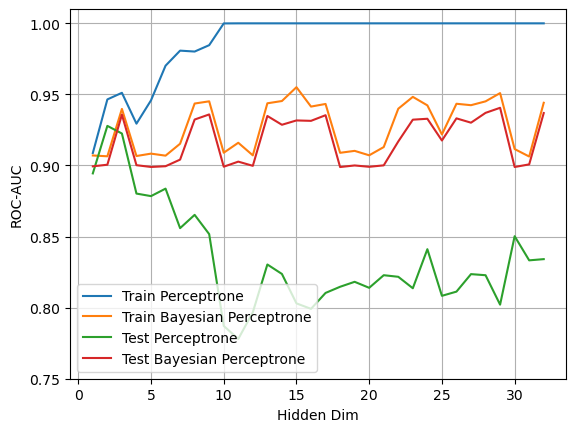

In [7]:
fig, ax = plt.subplots()
ax.plot(df.index, df["classic_roc_auc_train"], label="Train Perceptrone")
ax.plot(df.index, df["bayesian_roc_auc_train"], label="Train Bayesian Perceptrone")
ax.plot(df.index, df["classic_roc_auc_test"], label="Test Perceptrone")
ax.plot(df.index, df["bayesian_roc_auc_test"], label="Test Bayesian Perceptrone")
ax.set_xlabel("Hidden Dim")
ax.set_ylabel("ROC-AUC")
# ax.set_ylabel("$e^{-loss}$")
ax.legend()
ax.grid(True)
ax.set_ylim(bottom=0.75, top=1.01)
plt.show()

График функции потерь от количества нейронов в скрытом слое в однослойной полносвязной сети

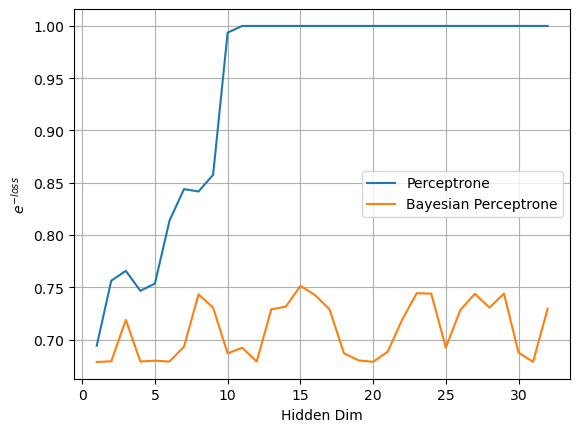

In [8]:
fig, ax = plt.subplots()
ax.plot(df.index, df["classic_p_item_average"], label="Perceptrone")
ax.plot(df.index, df["bayesian_p_item_average"], label="Bayesian Perceptrone")
ax.set_xlabel("Hidden Dim")
ax.set_ylabel("$e^{-loss}$")
ax.legend()
ax.grid(True)
plt.show()

Расчёт ранговой корреляции для ROC-AUC на тестовой выборке

In [9]:
df.corr(method="spearman").loc[["bayesian_loss", "bayesian_p_item_average", "bayesian_roc_auc_train"], "bayesian_roc_auc_test"]

bayesian_loss             -0.764663
bayesian_p_item_average    0.764663
bayesian_roc_auc_train     0.802419
Name: bayesian_roc_auc_test, dtype: float64